In [1]:
from phylo import celluloid, sasc, mp3
import glob
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import pickle
from colour import Color
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
#help(celluloid)

# Loading

In [3]:
patients = list()
patients_names = list()
for f in glob.glob('medullo/called/*.txt'):
    patients_names.append(f.split('/')[-1].replace('.txt', ''))
    p = celluloid.GenotypeMatrix(np.loadtxt(f, delimiter=' '),
                                 cell_labels=list(map(str.strip, open(f'{f}.cells').readlines())),
                                 mutation_labels=list(map(str.strip, open(f'{f}.muts').readlines()))
                                )
    patients.append(p)

# Clustering

In [4]:
clustered_patients = list()
for ix, p in enumerate(patients):
    try:
        c = celluloid.GenotypeMatrix.from_serializable_dict(
            pickle.load(open(f'medullo/clustered/{patients_names[ix]}.p', 'rb'))
        )
    except:
        c = celluloid.cluster_mutations(p, k=50, n_inits=5, max_iter=50, verbose=True)
        pickle.dump(c.to_serializable_dict(), open(f'medullo/clustered/{patients_names[ix]}.p', 'wb'))
    clustered_patients.append(c)

In [5]:
def build_colormap(unclustered, clustered):
    mapping = dict()
    for ix, l in enumerate(clustered):
        for ll in l.split(','):
            mapping[ll] = ix
            
    colors = list()
    for l in unclustered:
        colors.append(mapping[l])
        
    return colors

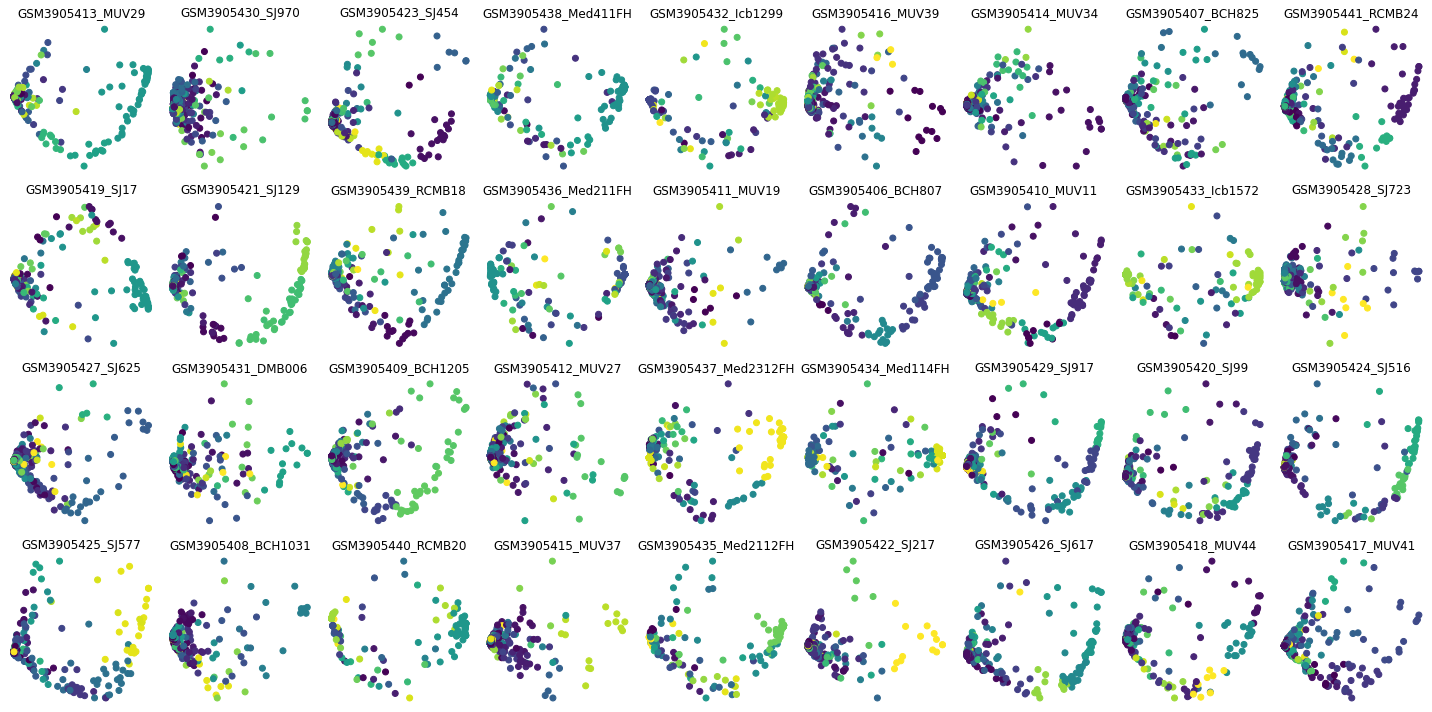

In [6]:
from sklearn.manifold import TSNE

COLS = 9
fig, axes = plt.subplots(nrows=int(len(clustered_patients)/COLS), ncols=COLS, figsize=(20,10))
ax = axes.flatten()
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

for ix, c in enumerate(clustered_patients):
    red = pca.fit_transform(patients[ix].matrix().transpose())
#     red = tsne.fit_transform(patients[ix].matrix().transpose())
    ax[ix].scatter(x=red[:,0], y=red[:,1], c=build_colormap(patients[ix].mutation_labels, c.mutation_labels))
    
    ax[ix].set_axis_off()
    ax[ix].set_title(patients_names[ix])

plt.tight_layout()
plt.savefig('medullo/mutclusters.pdf')
plt.show()

# Phylogeny inference

In [7]:
#help(sasc)

In [8]:
inferred_trees = list()
for ix, p in enumerate(clustered_patients):
    try:
        t = pickle.load(open(f'medullo/inferred/{patients_names[ix]}.p', 'rb'))
    except:
        t = sasc.infer_tree(p, alphas=0.25, beta=1e-4, k=0, max_deletions=0, cores=4, get_cells=True)
        pickle.dump(t, open(f'medullo/inferred/{patients_names[ix]}.p', 'wb'))
#     t = sasc.infer_tree(p, alphas=0.25, beta=1e-4, k=1, max_deletions=2, cores=4, get_cells=True)
    inferred_trees.append(t)

# Plot inferred trees (update)

In [9]:
def get_label_to_id_map(tree):
    return {
        node: '' if 'label' not in tree.nodes[node] else tree.nodes[node]['label']
        for node in tree
    }

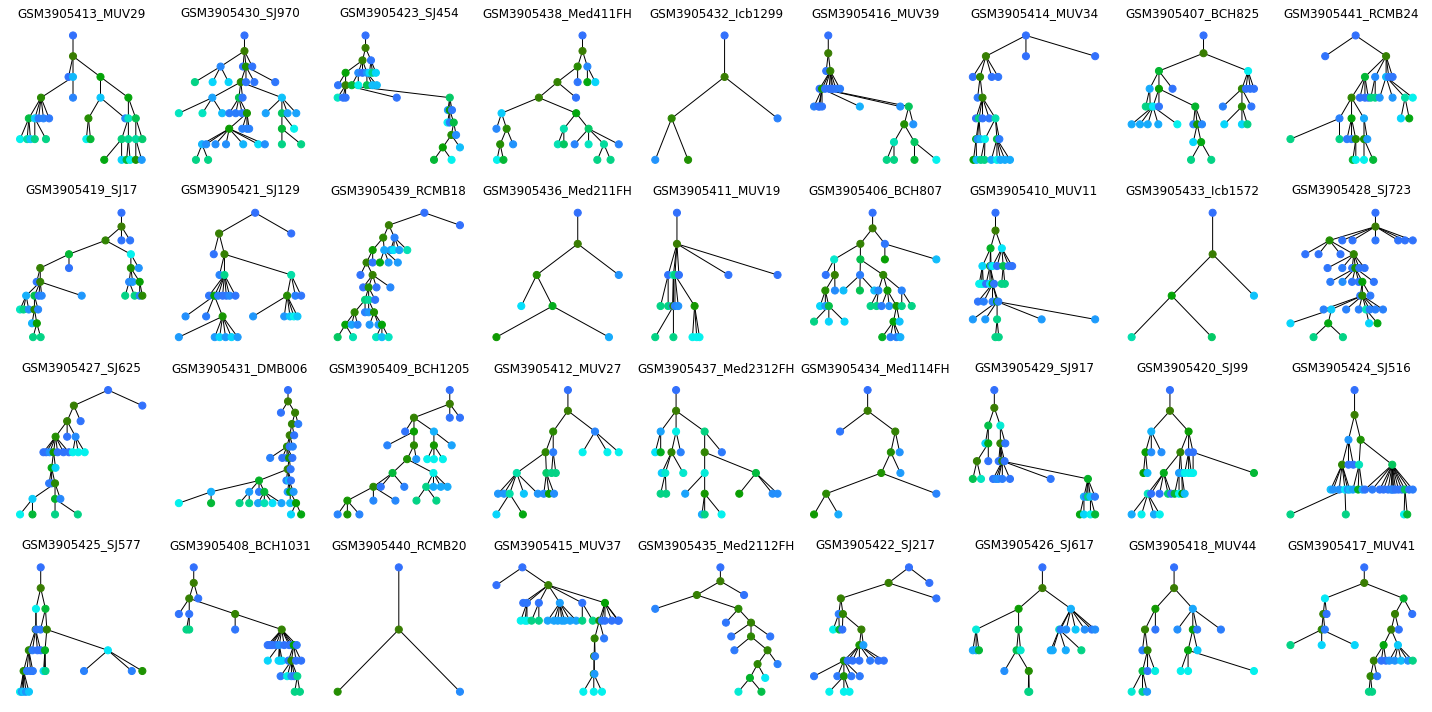

In [10]:
COLS = 9
fig, axes = plt.subplots(nrows=int(len(inferred_trees)/COLS), ncols=COLS, figsize=(20,10))
ax = axes.flatten()
c_gradient = list(Color("#3270FC").range_to(Color("#397D02"), 101))


for ix, p in enumerate(inferred_trees):
    t = p['inferred_tree'].with_visualization_features(support_threshold=0.2, collapse_simple_paths=True).as_digraph()
    p['inferred_tree'].without_cells().draw_to_file(f'medullo/trees/{patients_names[ix]}.gv')
    nx.draw(
        t,
        pos=nx.nx_agraph.graphviz_layout(t, prog="dot"),
#         labels=get_label_to_id_map(t),
        node_size=50,
        node_color=[c_gradient[int(v)].hex for k, v in nx.get_node_attributes(t,'support').items()],
        arrowstyle='-',
        ax=ax[ix]
    )
    ax[ix].set_axis_off()
    ax[ix].set_title(patients_names[ix])

plt.tight_layout()
plt.savefig('medullo/trees.pdf')
plt.show()

# Compare trees

In [21]:
similarity_matrix = np.ones((len(inferred_trees), len(inferred_trees)))

# for i in range(similarity_matrix.shape[0]):
#     for j in range(i+1, similarity_matrix.shape[1]):
#         s = mp3.tree_similarity(
#             inferred_trees[i]['inferred_tree'].without_cells(),
#             inferred_trees[j]['inferred_tree'].without_cells(),
#             cores=8
#         )
#         similarity_matrix[i][j] = s
#         similarity_matrix[j][i] = s

In [30]:
for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        try:
            s = float(open(f'medullo/mp3/{patients_names[i]}.{patients_names[j]}.txt', 'r').readlines()[0].strip())
            similarity_matrix[i][j] = s
            similarity_matrix[j][i] = s
        except:
            s = -1
#             similarity_matrix[i][j] = s
#             similarity_matrix[j][i] = s

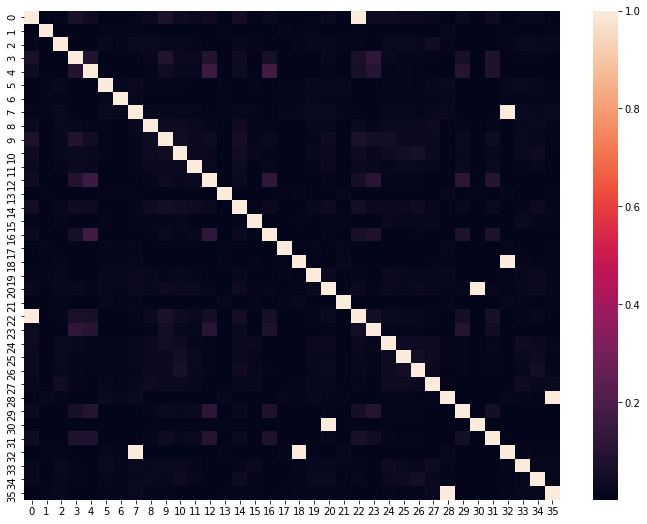

In [42]:
plt.figure(figsize=(12,9))
sns.heatmap(similarity_matrix)
plt.savefig('medullo/sim.pdf')
plt.show()

# Hierarchical clustering

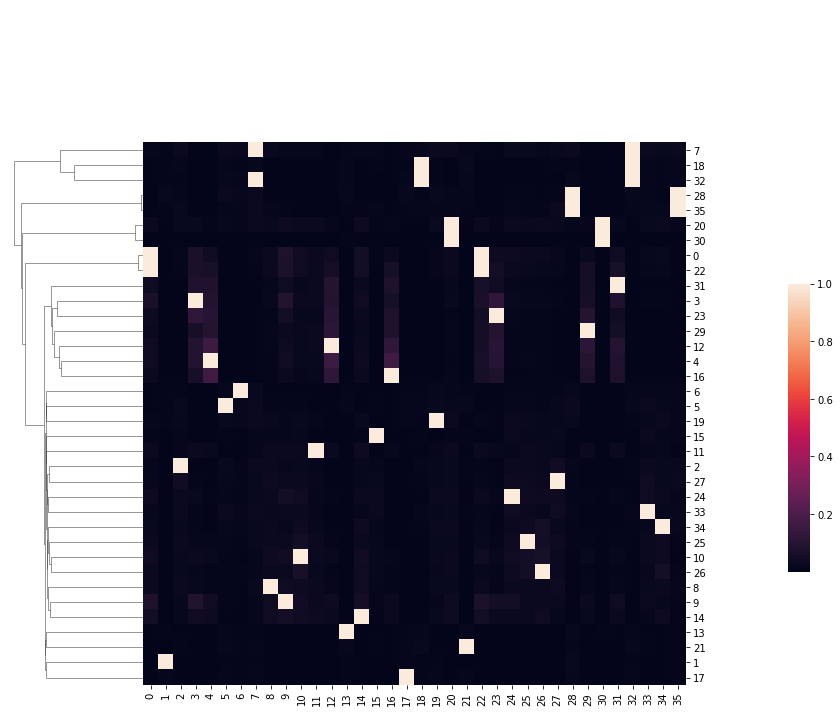

In [46]:
sns.clustermap(similarity_matrix, cbar_pos=(1.1, .2, .03, .4), col_cluster=False)
plt.savefig('medullo/clustermap.pdf')
plt.show()

<AxesSubplot:>

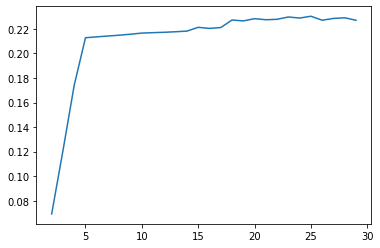

In [27]:
from sklearn.metrics import silhouette_score


# Transform the similarity matrix to a distance matrix
# as needed for a silhouette score computation

dist_matrix = np.zeros_like(similarity_matrix)
for index, _ in np.ndenumerate(similarity_matrix):
    dist_matrix[index] = 1 - similarity_matrix[index]
    

# Compute silhouette scores at different cuts
sil_scores = list()
for n_clust in range(2, 30):
    nodes = fcluster(Z, n_clust, criterion="maxclust")
    sil_scores.append(silhouette_score(dist_matrix, nodes, metric='precomputed'))
    
sns.lineplot(x=range(2, 30), y=sil_scores)

In [26]:
from scipy.cluster.hierarchy import linkage, fcluster

# Build linkage clustering
Z = linkage(similarity_matrix)

# Get labelling with a cut of 3 clusters
labels = fcluster(Z, 5, criterion="maxclust")
print(labels)

[4 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 3 5 2 5 4 5 5 5 5 5 1 5 2 5 3 5 5 1]
